# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
from imp import reload

# My modules
import sys
sys.path.append('/home/evan/git/QwikPlot/src/')
import qwikplot as qp
reload(qp)

# Python modules
import collections
import glob
import itertools
import time
import math
import os
import warnings

# 3rd party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

#qp.set_style(style='pub_1col', save_dir='../doc/images/')

workdir = '/home/evan/git/HF-Stability/analysis/'

datadir = workdir + 'log'

%matplotlib inline

## Load the Data
---

The data is parsed and collected in a pandas dataframe

In [2]:
dataframes = []
for f in glob.glob(datadir + '/*.json'):
    dataframes.append(qp.json_to_df(f, replace={'inf': 'NaN', 'nan': 'NaN'}))
df = pd.concat(dataframes, ignore_index=True)

/home/evan/git/QwikPlot/src/jsonpandas.py:34: UserWarning: Error Loading: /home/evan/git/HF-Stability/analysis/log/000001.000_00067_3_cRHF2cRHF_lgvdPu.json: Expecting ',' delimiter: line 33 column 4148716 (char 9687040)
  warnings.warn('Error Loading: ' + json_filename + ': ' + str(e))


## Clean Data


In [27]:
def reduce_evals(row):
    if not math.isnan(row['full_diag_min']) and abs(row['full_diag_min'] > 1e-7):
        return row['full_diag_min']
    elif abs(row['dav_min_eval'] > 1e-7):
        return row['dav_min_eval']
    else:
        return math.nan
    
# Remove data with critical values missing
df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk', 'mycase', 'dav_min_eval'], inplace=True)

# Collapse davidson and full diagonalization eigenvalues into one
df['min_eval'] = df.apply(reduce_evals, axis=1)
df.dropna(axis=0, subset=['min_eval'], inplace=True)

# type casting
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str).str.lstrip().str.rstrip()    

# keep only Triplet/Singlet Instabilities
df = df[np.logical_or(df['mycase'].str.match('cRHF2cRHF'), df['mycase'].str.match('cRHF2cUHF'))]

# Of course use_delta_1D must be false for ndim=2, 3
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D'] = False
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

df = df.drop_duplicates(subset=['NDIM', 'rs', 'Nk', 'mycase', 'twoE_parameter_1dCase'
                               , 'use_delta_1D'])

data = {
    '2dr2r': df[np.logical_and(df['NDIM'] == 2, df['mycase'].str.match('cRHF2cRHF'))],
    '1dr2r': df[np.logical_and(df['NDIM'] == 1, df['mycase'].str.match('cRHF2cRHF'))],
    '2dr2u': df[np.logical_and(df['NDIM'] == 2, df['mycase'].str.match('cRHF2cUHF'))],
    '1dr2u': df[np.logical_and(df['NDIM'] == 1, df['mycase'].str.match('cRHF2cUHF'))]
}

## Analytic Energy Functions

In [4]:
def f2D(y):
    if y <= 1.0:
        #scipy and guiliani/vignale define K and E differently, x -> x*x
        return sp.ellipe(y*y)
    else:
        #scipy and guiliani/vignale define K and E differently, x -> x*x
        x = 1.0 / y
        return y * (sp.ellipe(x*x) - (1.0 - x*x) * sp.ellipk(x*x))

def f3D(y):
    if y < 10e-10:
        return 1.0
    return 0.5 + (1 - y*y) / (4*y) * math.log(abs((1+y) / (1-y)))

def analytic_exch(k, kf, ndim):
    const = -2.0 * kf / math.pi
    if ndim == 2:
        return const * f2D(k / kf)
    elif ndim == 3:
        return const * f3D(k / kf)

def analytic_energy(k, kf, ndim):
    x = np.linalg.norm(k)  #works on k of any dimension
    return (x*x / 2.0) + analytic_exch(x, kf, ndim)

In [5]:
def axplot_1stBZ(df, ax, df_idx, spec_alpha, scale, labels):
    # Draw Shapes
    kmax = df.iloc[df_idx]['kmax']
    kf   = df.iloc[df_idx]['kf']
    kgrid= df.iloc[df_idx]['kgrid']
    vir_states = df.iloc[df_idx]['vir_states']
    occ_states = df.iloc[df_idx]['occ_states']

    circle = plt.Circle((0, 0), radius=kf, fc='none', linewidth=1, zorder=4)
    sqrpoints = [[kmax, kmax]
                ,[kmax, -kmax]
                ,[-kmax, -kmax]
                ,[-kmax, kmax]]
    square = plt.Polygon(sqrpoints, edgecolor=sns.color_palette()[0], fill=None, zorder=4)
    ax.add_patch(circle)
    ax.add_patch(square)

    # Get 'spectator virtuals'
    kvir_y = kgrid[vir_states[:, 1]]
    is_spec = np.logical_or((kvir_y > kf), (kvir_y < -kf))
    mask = np.where(is_spec)
    spec_virs = kgrid[vir_states[mask]]
    mask2 = np.where(np.logical_not(is_spec))
    active_virs = kgrid[vir_states[mask2]]

    ax.scatter(kgrid[occ_states[:,0]], kgrid[occ_states[:,1]],
                c=sns.color_palette()[0], label='Occupied', s=8, zorder=3, edgecolors='none')
    vir_color = sns.color_palette()[2]
    spec_vir_color = (255.0/255, 204./255, 153./255) 

    ax.scatter(active_virs[:,0], active_virs[:,1],
                c=vir_color, label='Virtual', s=8, zorder=2, edgecolors='none')
    ax.scatter(spec_virs[:,0], spec_virs[:,1],
                c=spec_vir_color, alpha=spec_alpha, label='Spectator Virtuals', 
                s=8, zorder=1, edgecolors='none')
    ax.set_xlim(-scale*kmax, scale*kmax)
    ax.set_ylim(-scale*kmax, scale*kmax)
    rs = df.iloc[df_idx]['rs']
    Nk = df.iloc[df_idx]['Nk']
    ndim = df.iloc[df_idx]['NDIM']
    title = 'rs = ' + str(rs)[:3] + ' Nk = ' + str(Nk) + ' ndim = ' + str(ndim)
    if labels:
        # ax.set_title(title)
        ax.set_xlabel('k${}_x$')
        ax.set_ylabel('k${}_y$')
        ax.legend(loc='center left', bbox_to_anchor=[0.95, 0.5])
    sns.despine(left=True, bottom=True)
    # ax.axis('off')
    return ax

In [6]:
def axplot_exc_hist(df, ax, df_idx, bindivisor=4):
        exc_energies = df.iloc[df_idx]['exc_energies']
        Nexc = df.iloc[df_idx]['Nexc']
        ax.hist(exc_energies, bins=Nexc/bindivisor)
        rs = df.iloc[df_idx]['rs']
        Nk = df.iloc[df_idx]['Nk']
        ndim = df.iloc[df_idx]['NDIM']
        title = 'r_s = ' + str(rs)[:3] + ' Nk = ' + str(Nk) + ' ndim = ' + str(ndim)
#       ax.set_title(title)
        ax.set_xlabel('$\epsilon_{vir} - \epsilon_{occ}$ (Hartree)')
        ax.set_ylabel('Count')
        return ax

In [7]:
def axplot_energy_compare(df, ax, df_idx, discretized=True, analytic=True):
    df_row = df.iloc[df_idx]
    kmax = df_row['kmax']
    ndim = df_row['NDIM']
    kf = df_row.kf
    Ef = kf**2 / 2.0

    # Analytic plots
    k = np.linspace(0, kmax, 500)
    kinetic = (0.5 * k*k) / Ef
    exch    = [analytic_exch(ki, kf, ndim) for ki in k] / Ef #rescale
    energy  = [analytic_energy(ki, kf, ndim) for ki in k] / Ef
    
    k = k / kf # rescale for plot
    if analytic:
        ax.plot(k, energy , 'k-' , label='Total', zorder=1)
        ax.plot(k, kinetic, 'k:' , label='Kinetic', zorder=1)    
        ax.plot(k, exch   , 'k--', label='Exchange', zorder=1)
    
    # Discrete plots
    occ_energies = df_row['occ_energies'] / Ef
    vir_energies = df_row['vir_energies'] / Ef
    kgrid = df_row['Kgrid']
    occ_states = df_row['occ_states']
    vir_states = df_row['vir_states']
    kocc = kgrid[occ_states]
    kocc = [np.linalg.norm(ki) for ki in kocc] / kf
    kvir = kgrid[vir_states]
    kvir = [np.linalg.norm(ki) for ki in kvir] / kf
    if discretized:
        ax.scatter(kocc, occ_energies, c=sns.color_palette()[0], label='Occupied',
                   s=2, zorder=2, edgecolors='none')
        ax.scatter(kvir, vir_energies, c=sns.color_palette()[2], label='Virtual', 
                   s=2, zorder=2, edgecolors='none')
        
    # Plot Options
    ax.set_xlim(0, 2)
    ax.set_ylim(-4, 4)
    ax.set_xlabel(r'$\frac{k}{k_f}$')
    ax.set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')
    return ax

In [8]:
def axplot_eval_convergence(df, ax, df_idx):
    df_row = df.iloc[df_idx]
    rs = df_row['rs']
    Nk = df_row['Nk']
    eigval = df_row['full_diag_min']
    ndim = df_row['NDIM']
    its = df_row['dav_its']
    num_evals = df_row['dav_num_evals']
    davvals = davvals.reshape(its, num_evals)
    its = len(davvals)
    x = range(1, its + 1)
    idx = np.argsort(davvals[:, -1])



    blues= sns.color_palette('GnBu_d', num_evals)
    reds = sns.color_palette('Reds_r', num_evals)

    cols = blues

    if abs(eigval - np.amin(davvals[-1, :])) > 1E-4:
        cols = reds

    title = 'r_s = ' + str(rs) + ' Nk = ' + str(Nk) + ' ndim = ' + str(ndim)
    # ax.set_title(title)
    for i in range(num_evals):
        ax.plot(x, davvals[:, i], 'o-', c=cols[i])
    return ax

### Runtimes 
--- 

Me getting an idea of runtimes and scalings for various procedures. This is not meant for presentation, but for spotting obvious outliers and strange scalings, etc. 

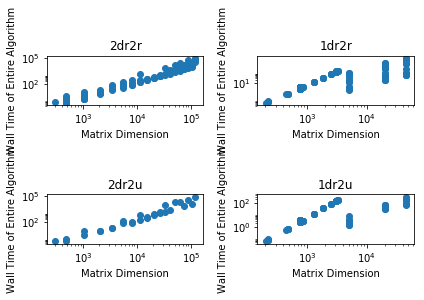

In [9]:
def plot_runtime(df, ax, *args, **kwargs):
    Walltime = df['total_calculation_time'].astype(str).apply(lambda x: x.split(' s')[0])
    Walltime = Walltime.as_matrix().astype(np.float)
    Nexcs = df.Nexc.as_matrix()
    # ax.set_title('Algorithm Runtime')
    ax.set_xlabel('Matrix Dimension')
    ax.set_ylabel('Wall Time of Entire Algorithm')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.scatter(2*Nexcs, Walltime, *args, **kwargs)

fig = plt.figure()
qp.subplotByDfDict(data, fig, plot_runtime)
plt.tight_layout()
plt.show()

/home/evan/local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/evan/local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/home/evan/local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


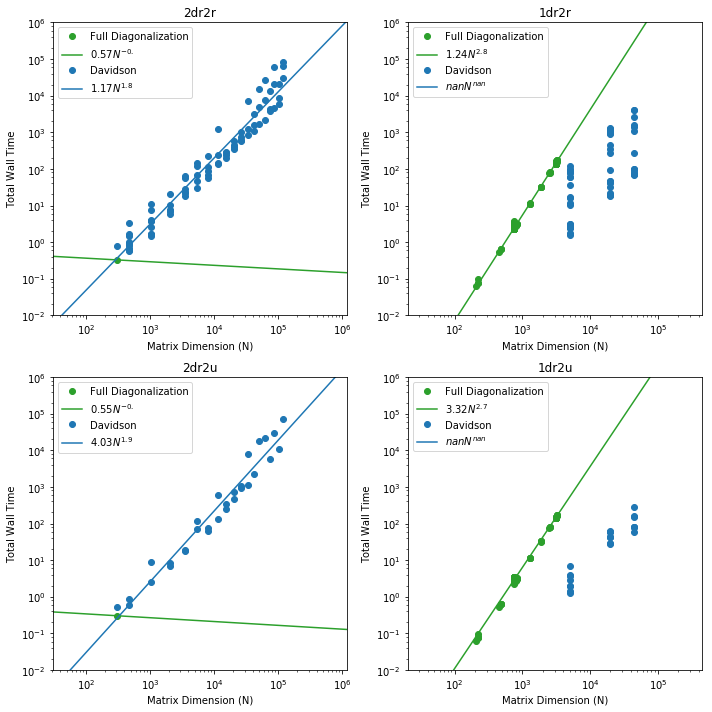

In [28]:
def plot_diag_scaling(df, ax):
    if len(df) == 0:
        return ax
    Nmat = 2 * df.Nexc.as_matrix()
    Davtimes =  df.dav_time.as_matrix()

    df_with_fulldiags = df[df['full_diag_min'].notnull()]
    fulltimes = df_with_fulldiags.full_diag_time.as_matrix()
    include_full = np.any(fulltimes > 1e-7) 
    Nmatfull = 2 * df_with_fulldiags.Nexc.as_matrix()

    xmax = np.amax(Nmat) * 10
    xmin = np.amin(Nmat) / 10.0
    ymax = np.amax(Davtimes) * 10
    ymin = np.amin(Davtimes) / 10.0
    Nfit = np.linspace(xmin, xmax, 500)

    # Full diagonalization
    if include_full:
        c = np.polyfit(np.log10(Nmatfull)[-10:], np.log10(fulltimes)[-10:], 1)
        fit = 10**(c[1]) * Nfit ** (c[0])
        ax.plot(Nmatfull, fulltimes, 'o', label='Full Diagonalization', c=sns.color_palette()[2])
        fitlabel = "$" + str(10**c[1])[:4] + " N^{" + str(c[0])[:3] + "}$"
        ax.plot(Nfit, fit, c=sns.color_palette()[2], label=fitlabel)

    # Davidson
    cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)
    davfit = 10**(cdav[1]) * Nfit ** (cdav[0])

    ax.plot(Nmat, Davtimes, 'o', label="Davidson", c=sns.color_palette()[0])
    fitlabel = "$" + str(10**cdav[1])[:4] + " N^ {" + str(cdav[0])[:3] + "}$"
    ax.plot(Nfit, davfit, c=sns.color_palette()[0], label=fitlabel)

    ax.set_xlabel('Matrix Dimension (N)')
    ax.set_ylabel('Total Wall Time')
    ax.legend(loc='best')

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([1e-2, 1e6])
    ax.set_xscale("log")
    ax.set_yscale("log")

fig = plt.figure(figsize=(10, 10))
qp.subplotByDfDict(data, fig, plot_diag_scaling)
plt.tight_layout()
plt.show()

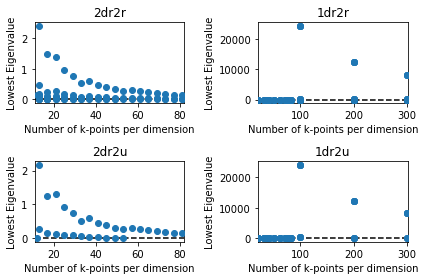

In [11]:
def plot_dav_vs_full(df, ax):
    df_with_fulldiags = df[df['full_diag_min'].notnull()]
    Nks_full = df_with_fulldiags.Nk.as_matrix()
    Nks = df.Nk.as_matrix()
    davmins = df.dav_min_eval.as_matrix()
    xmin = np.amin(Nks)-1
    xmax = np.amax(Nks) + 1
    ax.set_xlim(xmin, xmax)
    fullmins = df_with_fulldiags.full_diag_min.as_matrix()
    fullmins = fullmins[np.where(np.abs(fullmins) > 1e-5)]

    npts = 10
    zeros = np.zeros(npts)
    x = np.linspace(xmin, xmax, npts)

    ax.set_xlabel("Number of k-points per dimension")
    ax.set_ylabel('Lowest Eigenvalue')
    ax.plot(x, zeros   , 'k--', zorder=1)
    ax.scatter(Nks, davmins , zorder=3, c=sns.color_palette()[0])
#    if len(fullmins) > 0:
#        ax.scatter(Nks_full, fullmins, c=sns.color_palette()[2],
#                   zorder=2, label='Exact Lowest Eigenvalue')
#    ax.legend(loc='best')


fig = plt.figure()
qp.subplotByDfDict(data, fig, plot_dav_vs_full)
plt.tight_layout()
plt.show()

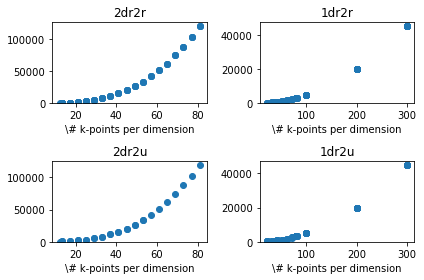

In [12]:
def plot_matrix_scaling(df, ax, *args, **kwargs):
    Nexcs = df.Nexc.as_matrix()
    Nks = df.Nk.as_matrix()
    ax.scatter(Nks, 2*Nexcs, *args, **kwargs)
    ax.set_ylim(0, np.amax(2.1*Nexcs))
    ax.set_xlabel('\# k-points per dimension')
    ax.set_label('Size of Matrix')
    # ax.set_title('Matrix Size Scaling')

fig = plt.figure()
qp.subplotByDfDict(data, fig, plot_matrix_scaling)
plt.tight_layout()
plt.show()

/home/evan/local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


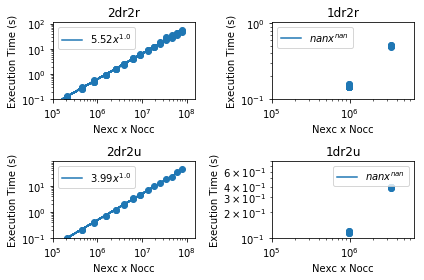

In [13]:
def plot_mvproduct_scaling(df, ax, scale=2):
    Nexcs = df['Nexc']
    Noccs = df['Nocc']
    mvtimes = df['mv_time']
    x = Nexcs * Noccs

    #  ax.set_title('Matrix - Vector Product Scaling')
    if len(df) > 2:
        x_split = np.array_split(x, 2)[1]
        mvtimes_split = np.array_split(mvtimes, 2)[1]

    c = np.polyfit(np.log10(x_split), np.log10(mvtimes_split),  1)
    fit = 10**(c[1]) * x**(c[0])
    fitlabel = "$" + str(10**c[1])[:4] + " x^ {" + str(c[0])[:3] + "}$"
    
    ax.plot(Nexcs*Noccs, fit, label=fitlabel)
    ax.legend()
    ax.scatter(Nexcs*Noccs, mvtimes)
    ax.set_xlabel('Nexc x Nocc')
    ax.set_ylabel('Execution Time (s)')
    scale = 2
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e5, np.amax(Nexcs * Noccs)*scale)
    ax.set_ylim(1e-1, np.amax(mvtimes)*scale)

fig = plt.figure()
qp.subplotByDfDict(data, fig, plot_mvproduct_scaling)
plt.tight_layout()
plt.show()

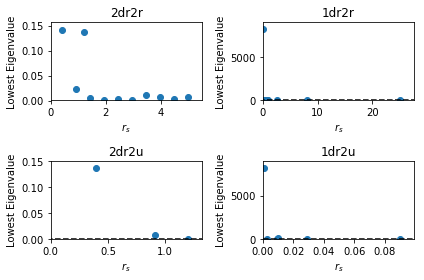

In [14]:
def plot_stability(df, ax, *args, **kwargs):
    ax.scatter(df['rs'], df['dav_min_eval'], *args, **kwargs)
    ax.plot(np.linspace(-5, 100, 100), np.zeros(100), 'k--')
    scale = 1.1
    xmin = 0
    xmax = np.amax(df['rs']) * scale
    ymin = np.amin(df['dav_min_eval']) * scale
    ymax = np.amax(df['dav_min_eval']) * scale
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('Lowest Eigenvalue')
    ax.set_xlabel('$r_s$')

fig = plt.figure()


subview = {key: qp.only_max(df, 'Nk', 'rs') for (key, df) in data.items()}


qp.subplotByDfDict(subview, fig, plot_stability)
plt.tight_layout()
plt.show()

/home/evan/local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Subset plot failed for case = cRHF2cRHF.This likely means the dataframe was empty for given conditions.
/home/evan/local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: Subset plot failed for case = cRHF2cUHF.This likely means the dataframe was empty for given conditions.


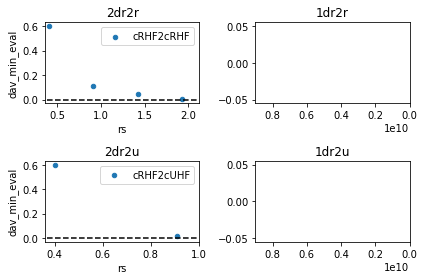

In [15]:
fig = plt.figure()

def plot_stability(df, ax):
    """Plot the stability for df on axis ax using the subset of nk.
    
    nk = 'all', 'max', or an integer value
    """
    colors = itertools.cycle(sns.color_palette())
    nk =  '37'
    
    ax.plot(np.linspace(-5, 100, 100), np.zeros(100), 'k--')
    xmin = 1.0e10
    xmax = -1.0
    
    for case, color in zip(df.mycase.unique(), colors):
        df_subset = df[df.mycase.str.match(case)]
        if nk == 'all':
            pass
        elif nk == 'max':
            df_subset = qp.only_max(df_subset, maximize='Nk', unique='rs')
        else:
            try:
                df_subset = df_subset[df_subset.Nk == int(nk)]
            except:
                raise ValueError('nk must be castable to an int contained in df.nk')
            
        try:
            df_subset.plot.scatter(x="rs", y="dav_min_eval", ax=ax, c=color, label=case)
            new_min = np.amin(df_subset.rs)
            new_max = np.amax(df_subset.rs)
            if new_min < xmin:
                xmin = new_min
            if new_max > xmax:
                xmax = new_max
        except TypeError:
            warnings.warn(('Subset plot failed for case = {}.' 
                          +'This likely means the dataframe was empty for given conditions.').format(case))
            
    ax.set_xlim((0.9 * xmin, 1.1 * xmax))

qp.subplotByDfDict(fig=fig, axplot=plot_stability, dfdict=data)

In [16]:
gp = data[('1d', 'rhf2uhf')].groupby('rs')

nrows, ncols = qp.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

KeyError: ('1d', 'rhf2uhf')

In [ ]:
gp = data[('1d', 'rhf2rhf')].groupby('rs')

nrows, ncols = qp.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

### Note: 17 May 2017
---
Checked whether the RHF-RHF being lower than RHF-UHF was due to changes in build. Both builds display the same
feature. I'm not sure if this is an error at this point. 

In [ ]:
mask = data[('1d', 'rhf2uhf')].apply(
    lambda row: row['build_date'] == 'Apr  8 2017-16:05:45', axis=1)
mask2 = np.asarray([i for i in mask])
dat_build1_r2u = data[('1d', 'rhf2uhf')][mask2]

mask = data[('1d', 'rhf2rhf')].apply(
    lambda row: row['build_date'] == 'Apr  8 2017-16:05:45', axis=1)
mask2 = np.asarray([i for i in mask])
dat_build1_r2r = data[('1d', 'rhf2rhf')][mask2]


dfr2rmax = qp.only_max(dat_build1_r2r, maximize='Nk', unique='rs')
dfr2umax = qp.only_max(dat_build1_r2u, maximize='Nk', unique='rs')

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['full_diag_min'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
plt.xscale('log')
plt.yscale('symlog')
plt.xlim(1e-4, 1e2)
plt.ylim(-1e4, 1e6)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 1D')
plt.legend()
plt.tight_layout()
plt.savefig('1dstab.pdf')
plt.show()

In [ ]:
dfr2rmax = qp.only_max(data[('2d', 'rhf2rhf')], maximize='Nk', unique='rs')
dfr2umax = qp.only_max(data[('2d', 'rhf2uhf')], maximize='Nk', unique='rs')

dfr2rmax = dfr2rmax[dfr2rmax.Nk == 77]
dfr2umax = dfr2rmax[dfr2rmax.Nk >= 57]
#print(dfr2r77.Nk)

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['dav_min_eval'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['dav_min_eval'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
#plt.xscale('log')
plt.xlim(1e-4, 3)
#plt.ylim(-2000, 35000)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 2D')
plt.legend()
plt.tight_layout()
plt.savefig('2dstab.pdf')
plt.show()

In [ ]:
#dfr2rmax = qp.only_max(data[('3d', 'rhf2rhf')], maximize='Nk', unique='rs')
dfr2umax = qp.only_max(data[('3d', 'rhf2uhf')], maximize='Nk', unique='rs')
dfr2umax45 = dfr2umax[dfr2umax['Nk'] == 45]
dfr2umax37 = dfr2umax[dfr2umax['Nk'] == 37]
fig = plt.figure()
#plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax45['rs'], dfr2umax45['dav_min_eval'], label='Nk=45')
plt.scatter(dfr2umax37['rs'], dfr2umax37['dav_min_eval'], label='Nk=37')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--', lw=1)
#plt.xscale('log')
plt.xlim(1e-4, 10)
plt.ylim(-0.1, 0.1)
ax = plt.gca()
#ax.set_yticks([-0.1, -0.1])

plt.xlabel('$r_s$')
#plt.yscale('symlog')
plt.ylabel('$Lowest~Eigenvalue$')
#plt.title('$Stability~in~3D$')
plt.legend()
plt.tight_layout()
plt.savefig('3dstab.pdf')
plt.show()

## Testing RHF-GHF, RHF-UHF equivalence, various matrix factorizations
---

Starting from the RHF solution, I've shown mathematically that the various instabilities factorize into only two types, RHF-RHF and RHF-UHF. The Other instabilities can all be expressed as combinations of these. This is the numerical verification of the mathematics. 

In [ ]:
"""

temp = data['2D'][data['2D']['Nk'] == 12].dropna(subset=['exact_evals'])
evaldic = {temp['mycase'].iloc[i] : temp['exact_evals'].iloc[i] for i in range(len(temp))}

fig = plt.figure()
for key, val in evaldic.items():
    plt.plot(range(len(val)), val, label=key)
    

sort = np.sort(np.concatenate([ evaldic['cRHF2cRHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF'] ]))
plt.plot(range(len(sort)), sort, label='3rhf2uhf and 1')
plt.legend()
plt.show()

print("All within 1e-10? : ", np.all(np.abs(sort - evaldic['cRHF2cGHF']) < 1e-10))

# the histogram of the data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax1.hist(evaldic['cRHF2cGHF'], bins=binset, histtype='bar', stacked=True, label="$\mathbf{H}$", fill=False, color='r'
        , linewidth=1.5, zorder=1)
ax1.hist(sort, bins=binset, histtype='bar', stacked=True, label="3 ${}^3\mathbf{H}'$ and 1 ${}^1\mathbf{H}'$", zorder=0)

ax1.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$")
ax1.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$")
ax1.set_title('Eigenvalue Factorization for RHF - GHF Matrix')
ax1.legend()
ax1.set_xlabel('Eigenvalue')
ax1.set_ylabel('Count')
ax1.set_xlim(xmin, xmax)

xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax2.hist(evaldic['cUHF2cUHF'], bins=binset, histtype='bar', stacked=True, 
         label="$\mathbf{H}'$", fill=False, linewidth=1.5, zorder=1)
ax2.hist(np.concatenate([evaldic['cRHF2cUHF'], evaldic['cRHF2cRHF']]), 
         bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$ and ${}^1\mathbf{H}'$", 
         color=sns.color_palette()[0], zorder=0)

ax2.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$", color=sns.color_palette()[1])
ax2.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$", color=sns.color_palette()[2])
ax2.set_xlim(xmin, xmax)
ax2.set_title('Eigenvalue Factorization for UHF - GHF Matrix')
ax2.legend()
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Count')
#plt.savefig('matrix_factor_histograms.pdf')
plt.show()
"""

# Analysis for 1D Case: Delta Function and Coulomb Potentials
---

The delta function potential was used by Overhauser in his paper and therefore is interesting to investigate computationally. The Coulomb potential is treated in a 'pseudo-1D' fashion, in which the space considered is a cylinder of width *a*, where the value of *a* is chosen to 'freeze' the motion of the electrons except for motion along the axis.  

In [ ]:
r2r = data[('1d', 'rhf2rhf')] 
r2u = data[('1d', 'rhf2uhf')] 

data['1D_delta_R2R'] = r2r[r2r['use_delta_1D'].astype(bool)]
data['1D_delta_R2U'] = r2u[r2u['use_delta_1D'].astype(bool)]

data['1D_coul_R2R'] = r2r[np.logical_not(r2r['use_delta_1D'].astype(bool))]
data['1D_coul_R2U'] = r2u[np.logical_not(r2u['use_delta_1D'].astype(bool))]

### For Delta Function Potential, RHF-UHF and RHF-RHF are equivalent. 
---

The singlet instability matrices are:

$A_{st} = (E_a - E_i)\delta_{st} + 2 (aj|ib) - (aj|bi)$

$B_{st} = -(ab|ji) + 2 (ab|ij)$

While the triplet instability matrices are:

$A_{st} = (E_a - E_i)\delta_{st} - (aj|bi)$

$B_{st} = -(ab|ji)$

Due to the symmetry of the two electron integrals under the delta function potential,
$(pq|rs) = (qp|rs) = (pq|sr) = (qp|sr)$

these differ only by the sign of all off diagonals, and have the same eigenspectra.

In [ ]:
maxdata_delta_R2U = data['1D_delta_R2U'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2U = qp.only_max(df=maxdata_delta_R2U, maximize='Nk', unique='rs')

maxdata_delta_R2R = data['1D_delta_R2R'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2R = qp.only_max(df=maxdata_delta_R2R, maximize='Nk', unique='rs')



fig = plt.figure()
plt.plot(np.linspace(1e-10, 1e10, 50), np.zeros(50), 'k--')
plt.xlim(0, 15)
plt.yscale('symlog')
plt.scatter(maxdata_delta_R2U['twoE_parameter_1dCase'], maxdata_delta_R2U['full_diag_min'])
plt.scatter(maxdata_delta_R2R['twoE_parameter_1dCase'], maxdata_delta_R2R['full_diag_min'])
plt.show()

## Testing Pandas merge (analagous to SQL Join)
---
This is very promising. Can join on multiple rows to compare two cases where all other params
are the same!

In [ ]:
def symlog(x):
    return np.sign(x) * np.log10(1 + np.abs(2*x))  

def sidebyside_heatmap(df1, df2):
    """Draws stability heatmaps for the rs and parameter
    
    The data colored by the symlog(x) function, but the colormap labels
    are the actual numbers. 
    
    """
    cols = ['NDIM', 'Nk', 'rs', 'mycase', 'twoE_parameter_1dCase', 'min_eval']
    merge_cols = ['NDIM', 'Nk', 'rs', 'twoE_parameter_1dCase']
    test = pd.merge(df1[cols], df2[cols], how='outer', on=merge_cols)
    test = test.set_index('rs').sort_index()

    newcols = { 'min_eval_x'      : 'RHF'
               ,'min_eval_y'      : 'UHF'
               ,'twoE_parameter_1dCase': 'a' 
              }
    test = test.rename(columns=newcols)

    test = test.set_index(['a'], append=True)

    fig, axes = plt.subplots(1, 2, figsize=(15,10), sharey=True)

    keys = [newcols[i] for i in ('min_eval_x','min_eval_y')]

    
    for idx, plot_axis in enumerate(axes):
        # Plot scaled data
        df = test[keys[idx]]
        df = df[~df.index.duplicated(keep='first')]
        unstacked = df.unstack(level=0)
        
        C = 1.0 / np.log(10)
        unstacked_scaled = symlog(unstacked)
        mask = unstacked_scaled.isnull()
        cmap = sns.diverging_palette(h_neg=240, h_pos=10, as_cmap=True, center='dark')

        sns.heatmap(unstacked_scaled, center=0.0, ax=plot_axis, mask=mask, cmap=cmap)
        
        rslist = [level for level in test.index.levels if level.name == 'rs'][0]
        rslist = np.round(np.log10(rslist), 1)
        plot_axis.set_xticklabels(rslist)
        plot_axis.set_title(keys[idx])
        a = np.asarray([level for level in test.index.levels if level.name == 'a'][0])
        
        ylabels = plot_axis.set_yticklabels(a)
        plot_axis.set_xlabel('log10(rs)')
        plot_axis.xaxis.set_ticks_position('none')
        plot_axis.yaxis.set_ticks_position('none') 
        
        # plot_axis.text(17.5, 6, 'Scaled Min EigVal', fontsize=12, rotation=-90)
        

        
    return fig, axes
    
# maxdata_coul_R2R_80Nk = data['1D_coul_R2R'][data['1D_coul_R2R']['Nk'] == 80]
# maxdata_coul_R2U_80Nk = data['1D_coul_R2U'][data['1D_coul_R2U']['Nk'] == 80]
# fig, axes = sidebyside_heatmap(maxdata_coul_R2R_80Nk, maxdata_coul_R2U_80Nk)
fig, axes = sidebyside_heatmap(maxdata_delta_R2R, maxdata_delta_R2U)
fig.suptitle('1D Coulomb Interaction Stability')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

"""
maxdata_delta_R2R = data['1D_delta_R2R'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2U = data['1D_delta_R2U'].dropna(subset=['twoE_parameter_1dCase'])
maxdata_delta_R2R_80Nk = maxdata_delta_R2R[maxdata_delta_R2R['Nk'] == 80]
maxdata_delta_R2U_80Nk = maxdata_delta_R2U[maxdata_delta_R2U['Nk'] == 80]
fig, axes = sidebyside_heatmap(maxdata_delta_R2R_80Nk, maxdata_delta_R2U_80Nk)
fig.suptitle('1D Delta Fxn Interaction Stability')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
for ax in axes:
    ax.set_ylabel('V0')
plt.show()
"""

## Above this Was mostly experimental findings used for working. Below This are images specifically tailored to the paper.
---

In [ ]:
sort = data[('1d', 'rhf2rhf')].sort_values('Nk', ascending=False)
r2r = sort.drop_duplicates(subset=['rs', 'NDIM', 'twoE_parameter_1dCase', 'use_delta_1D'])

sort = data[('1d', 'rhf2uhf')].sort_values('Nk', ascending=False)
r2u = sort.drop_duplicates(subset=['rs', 'NDIM', 'twoE_parameter_1dCase', 'use_delta_1D'])

#r2r = r2r[~r2r.index.duplicated(keep='first')]
#r2u = r2u[~r2u.index.duplicated(keep='first')]

fig, axes = sidebyside_heatmap(r2r, r2u)
fig.suptitle('1D Delta Function Interaction Stability')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
r2r['gamma'] = 2.0 * r2r['rs'] * r2r['twoE_parameter_1dCase']
test = r2r[['rs', 'Nk', 'twoE_parameter_1dCase', 'min_eval', 'gamma']]
test = test[test.Nk == 300].set_index('gamma').sort_index()
test

In [ ]:
fig = plt.figure()

#df = data['1dr2r']
#df.groupby(['twoE_parameter_1dCase'])
    

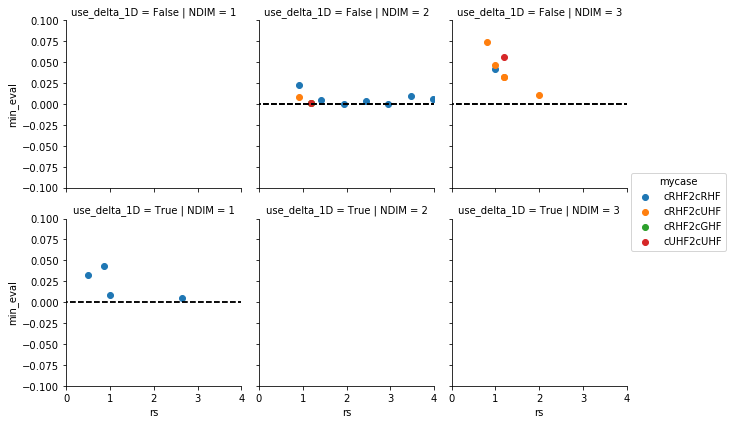

In [17]:
def test(x, y, **kwargs):
    x0 = np.linspace(-1, 100, 50)
    plt.plot(x0, np.zeros_like(x0), 'k--')
    plt.scatter(x, y, **kwargs)

gb = df.groupby(['NDIM', 'mycase', 'use_delta_1D'])
df2 = gb.apply(qp.only_max, maximize='Nk', unique='rs')
    
g = sns.FacetGrid(df2, row='use_delta_1D', col='NDIM', hue='mycase', xlim=(0.0, 4.0), ylim=(-0.1, 0.1))
g = (g.map(test, 'rs', 'min_eval').add_legend())

In [ ]:
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D']

##### 